
# FASTSim Demonstration

![fastsim icon](icon_fastsim.jpg)

Developed by NREL, the Future Automotive Systems Technology Simulator (FASTSim) evaluates the impact of technology improvements on efficiency, performance, cost, and battery life in conventional vehicles, hybrid electric vehicles (HEVs), plug-in hybrid electric vehicles (PHEVs), and all-electric vehicles (EVs).

FASTSim answers questions such as:
- Which battery sizes are most cost effective for a PHEV or EV?
- At what battery prices do PHEVs and EVs become cost effective?
- On average, how much fuel does a PHEV with a 30-mile electric range save?
- How much fuel savings does an HEV provide for a given drive cycle?
- How do lifetime costs and petroleum use compare for conventional vehicles, HEVs, PHEVs, and EVs?

FASTSim was originally implemented in Microsoft Excel. The pythonic implementation of FASTSim, demonstrated here, captures the drive cycle energy consumption simulation component of the software. The python version of FASTSim is more convenient than the Excel version when very high computational speed is desired, such as for simulating a large batch of drive cycles.

In [1]:
import sys
import os
from pathlib import Path
# allow it to find simdrive module
fsimpath=str(Path(os.getcwd()).parents[0])
if fsimpath not in sys.path:
    sys.path.append(fsimpath)
import numpy as np
import time
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import importlib
# import seaborn as sns
# sns.set(font_scale=2, style='whitegrid')

%matplotlib inline

In [2]:
# local modules
from fastsim import simdrive, vehicle, cycle
# importlib.reload(simdrive)
# importlib.reload(cycle)

## Individual Drive Cycle
### Load Drive Cycle

Default (UDDS, US06, HWFET) cycles can be loaded from the ```../cycles``` directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys: 

```['cycGrade', 'cycMps', 'cycSecs', 'cycRoadType']```
- cycGrade = Road grade [%/100]
- cycMps = Vehicle speed [meters per second]
- cycSecs = Relative time in the cycles [seconds]
- cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle

There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.

In [3]:
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

0.7400453090667725


### Load Powertrain Model

A vehicle database in CSV format is required to be in the working directory where FASTSim is running (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle attributes from the database and contructs the powertrain model (engine efficiency map, etc.). An integer value corresponds to each vehicle in the database. To add a new vehicle, simply populate a new row to the vehicle database CSV.

In [4]:
t0 = time.time()
veh = vehicle.Vehicle(1)
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

7.372830390930176


### Run FASTSim

The "sim_drive" function takes the drive cycle and vehicle models defined above as inputs. The output is a dictionary of time series and scalar values described the simulation results. Typically of interest is the "gge" key, which is an array of time series energy consumption data at each time step in the drive cycle.

If running FASTSim in batch over many drive cycles, the output from "sim_drive" can be written to files or database for batch post-processing. 

In [11]:
t0 = time.time()

sim_drive_params = simdrive.SimDriveParams(missed_trace_correction=True)
veh_jit.vehKg = 10e3
# sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit, sim_drive_params)
sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit, sim_drive_params)

sim_drive.sim_drive() 

print(time.time() - t0)

1.750356674194336


### Results

Text(0, 0.5, 'Speed [mps]')

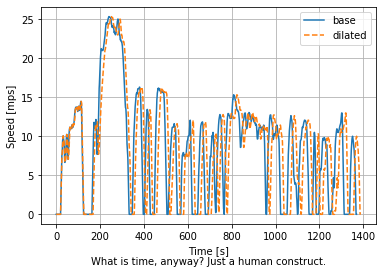

In [12]:
plt.plot(cyc.cycSecs, cyc.cycMps, label='base')
plt.plot(sim_drive.cyc.cycSecs, sim_drive.mpsAch, label='dilated', linestyle = '--')
plt.grid()
plt.legend()
plt.xlabel('Time [s]\nWhat is time, anyway? Just a human construct.')
plt.ylabel('Speed [mps]')

Text(0, 0.5, 'Speed [mps]')

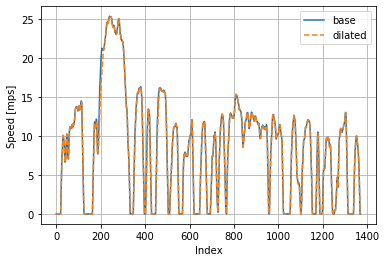

In [13]:
plt.plot(cyc.cycMps, label='base')
plt.plot(sim_drive.mpsAch, label='dilated', linestyle = '--')
plt.grid()
plt.legend()
plt.xlabel('Index')
plt.ylabel('Speed [mps]')

Text(0, 0.5, 'Distance [m]')

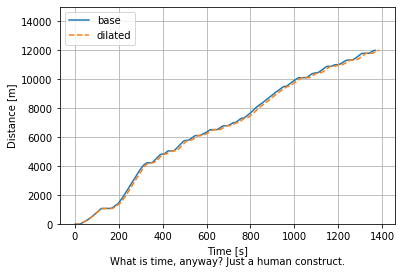

In [14]:
plt.plot(cyc.cycSecs, (cyc.cycMps * cyc.secs).cumsum(), label='base')
plt.plot(sim_drive.cyc.cycSecs, (sim_drive.mpsAch * sim_drive.cyc.secs).cumsum()
         , label='dilated', linestyle = '--')
plt.grid()
plt.legend(loc='upper left')
plt.ylim(0, 15000)
plt.xlabel('Time [s]\nWhat is time, anyway? Just a human construct.')
plt.ylabel('Distance [m]')

Text(0, 0.5, 'Distance [m]')

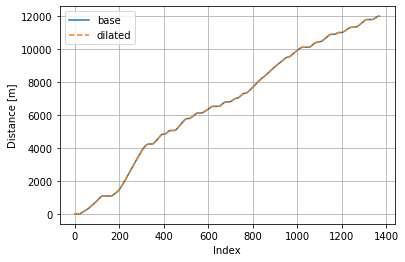

In [15]:
plt.plot((cyc.cycMps * cyc.secs).cumsum(), label='base')
plt.plot((sim_drive.mpsAch * sim_drive.cyc.secs).cumsum()
         , label='dilated', linestyle = '--')
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Distance [m]')